In [1]:
from collections import Counter
import os
import shutil
from urllib.parse import urlparse, urljoin
import ftplib
from zipfile import ZipFile
import gzip
import xml.etree.ElementTree as XML_ET
import csv
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm_notebook
%matplotlib inline

## Get list of .zip batch files to download

In [2]:
BASE_URL = 'ftp://ftp.ncbi.nlm.nih.gov/pubchem/'
BIOASSAY_DATA_FOLDER = 'Bioassay/CSV/Data'  # this folder contains .CSV files with measured compounds
BIOASSAY_DESC_FOLDER = 'Bioassay/CSV/Description'  # this folder contains info about assay e.g. the target

In [3]:
parsed_url = urlparse(BASE_URL)

In [4]:
try:
    with ftplib.FTP() as ftp:
        print(ftp.connect(parsed_url.netloc))
        print(ftp.login())
        print(ftp.cwd(os.path.join(parsed_url.path, BIOASSAY_DATA_FOLDER)))
        dir_list = ftp.nlst()
        dir_list_sizes = [x for x in ftp.mlsd(facts = ["type", "size"])]
except Exception as e:
    print(e)

220-
 This warning banner provides privacy and security notices consistent with 
 applicable federal laws, directives, and other federal guidance for accessing 
 this Government system, which includes all devices/storage media attached to 
 this system. This system is provided for Government-authorized use only. 
 Unauthorized or improper use of this system is prohibited and may result in 
 disciplinary action and/or civil and criminal penalties. At any time, and for 
 any lawful Government purpose, the government may monitor, record, and audit 
 your system usage and/or intercept, search and seize any communication or data 
 transiting or stored on this system. Therefore, you have no reasonable 
 expectation of privacy. Any communication or data transiting or stored on this 
 system may be disclosed or used for any lawful Government purpose.
220 FTP Server ready.
230 Anonymous access granted, restrictions apply
250 CWD command successful


In [5]:
dir_list[:10]

['0000001_0001000.zip',
 '0001001_0002000.zip',
 '0002001_0003000.zip',
 '0003001_0004000.zip',
 '0092001_0093000.zip',
 '0005001_0006000.zip',
 '0013001_0014000.zip',
 '0007001_0008000.zip',
 '0008001_0009000.zip',
 '0009001_0010000.zip']

In [6]:
dir_list_sizes[:10]

[('.', {'size': '69632', 'type': 'cdir'}),
 ('..', {'size': '4096', 'type': 'pdir'}),
 ('0000001_0001000.zip', {'size': '425423906', 'type': 'file'}),
 ('0001001_0002000.zip', {'size': '791478416', 'type': 'file'}),
 ('0002001_0003000.zip', {'size': '586939677', 'type': 'file'}),
 ('0003001_0004000.zip', {'size': '658847', 'type': 'file'}),
 ('0092001_0093000.zip', {'size': '684343', 'type': 'file'}),
 ('0005001_0006000.zip', {'size': '694767', 'type': 'file'}),
 ('0013001_0014000.zip', {'size': '557700', 'type': 'file'}),
 ('0007001_0008000.zip', {'size': '600294', 'type': 'file'})]

## Download a single batch

Download and extract

In [7]:
def get_batch(batch_filename):
    '''
    This downloads a .zip file with description and data and extracts it
    returns dict with info about the batch, such as paths to files etc.
    '''
    batch_name, batch_extension = os.path.splitext(batch_filename)
    if batch_extension != '.zip':
        raise Exception('Batch filename must have .zip extension ({})'.format(batch_filename))
    
    
    # We copy the folder structure of the server
    os.makedirs(BIOASSAY_DATA_FOLDER, exist_ok=True)
    os.makedirs(BIOASSAY_DESC_FOLDER, exist_ok=True)
    batch_data_path = os.path.join(BIOASSAY_DATA_FOLDER, batch_filename)
    batch_desc_path = os.path.join(BIOASSAY_DESC_FOLDER, batch_filename)
    
    
    # Download the files
    if not os.path.exists(batch_data_path) or not os.path.exists(batch_desc_path):
        try:
            with ftplib.FTP() as ftp, open(batch_data_path, 'wb') as f_data, open(batch_desc_path, 'wb') as f_description:
                print(ftp.connect(parsed_url.netloc))
                print(ftp.login())
                print(ftp.cwd(parsed_url.path))
                print(ftp.retrbinary('RETR ' + batch_data_path, f_data.write))
                print('Downloaded data file %s (%d MB)' % (batch_data_path, os.path.getsize(batch_data_path)//1024//1024))
                print(ftp.retrbinary('RETR ' + batch_desc_path, f_description.write))
                print('Downloaded desc file %s (%d MB)' % (batch_desc_path, os.path.getsize(batch_desc_path)//1024//1024))
        except ftplib.all_errors as e:
            print('There was and error with FTP connection')
            print(e)
        
    
    
    # Unzip the files
    batch_data_folder = os.path.join(BIOASSAY_DATA_FOLDER, batch_name)
    batch_desc_folder = os.path.join(BIOASSAY_DESC_FOLDER, batch_name)
    
    if not os.path.exists(batch_data_folder) or not os.path.exists(batch_desc_folder):
        with ZipFile(batch_data_path) as zf:
            zf.extractall(BIOASSAY_DATA_FOLDER)

        with ZipFile(batch_desc_path) as zf:
            zf.extractall(BIOASSAY_DESC_FOLDER)
    
    
        # Inside the .zip files should be a directory <batch_name> with (csv/xml).gz files that got extracted
        if not os.path.isdir(batch_data_folder) or not os.path.isdir(batch_desc_folder):
            raise Exception('Batch data or description folders were not correctly extracted ({}, {})'.format(batch_data_folder, batch_desc_folder))

    data_gz_filenames = os.listdir(batch_data_folder)
    desc_gz_filenames = os.listdir(batch_desc_folder)

#     extracted_data_size = sum(os.path.getsize(os.path.join(batch_data_folder,gz_file_name)) for gz_file_name in data_gz_filenames)
#     extracted_desc_size = sum(os.path.getsize(os.path.join(batch_desc_folder,gz_file_name)) for gz_file_name in desc_gz_filenames)
#     print('Extracted %d data files (%d KB)' % (len(data_gz_filenames), extracted_data_size//1024))
#     print('Extracted %d desc files (%d KB)' % (len(desc_gz_filenames), extracted_desc_size//1024))
    
    return {'batch_name':batch_name, 'batch_data_folder':batch_data_folder, 'batch_desc_folder':batch_desc_folder,'data_gz_filenames':data_gz_filenames, 'desc_gz_filenames':desc_gz_filenames}
    

In [8]:
def clean_up_batch(batch_filename):
    '''
    This removes the downloaded and extracted files
    '''
    batch_data_path = os.path.join(BIOASSAY_DATA_FOLDER, batch_filename)
    batch_desc_path = os.path.join(BIOASSAY_DESC_FOLDER, batch_filename)
    batch_name, batch_extension = os.path.splitext(batch_filename)
    batch_data_folder = os.path.join(BIOASSAY_DATA_FOLDER, batch_name)
    batch_desc_folder = os.path.join(BIOASSAY_DESC_FOLDER, batch_name)
    
    # Remove .zip files
    if os.path.exists(batch_data_path):
        os.remove(batch_data_path)
    if os.path.exists(batch_desc_path):
        os.remove(batch_desc_path)
    
    # Remove extracted folders
    if os.path.exists(batch_data_folder):
        shutil.rmtree(batch_data_folder)
    if os.path.exists(batch_desc_folder):
        shutil.rmtree(batch_desc_folder)

## Process assay descriptions

Extract information about the target

In [14]:
ASSAY_DESC_STATUS_MORE_TARGETS = 'more_targets'
ASSAY_DESC_STATUS_NO_TARGET = 'no_target'
ASSAY_DESC_STATUS_TARGET_NO_ACCESSION = 'target_no_accession'
ASSAY_DESC_STATUS_OK = 'ok'
ASSAY_DESC_STATUS_ERROR = 'error'

def process_assay_description(path_to_description):
    '''
    This processes the description .xml file to extract information about the target
    returns (status, assay_obj), where status can be one of ASSAY_DESC_STATUS_* constants; assay_obj is a dict and its fields vary according to the status
    In case of an error, returns (ASSAY_DESC_STATUS_ERROR, error_msg)
    '''
    with gzip.open(path_to_description, 'rt') as f:
        xml_tree = XML_ET.parse(f)
        
    namespaces = {'ncbi':'http://www.ncbi.nlm.nih.gov'}

    assay_id = xml_tree.find('.//ncbi:PC-ID_id', namespaces=namespaces).text
    assay_version = xml_tree.find('.//ncbi:PC-ID_version', namespaces=namespaces).text
    assay_obj = {'assay_id':assay_id, 'assay_version':assay_version}

    target_info_root_elements = xml_tree.findall('.//ncbi:PC-AssayTargetInfo', namespaces=namespaces)
    if len(target_info_root_elements) > 1:
        return ASSAY_DESC_STATUS_MORE_TARGETS, assay_obj
    if len(target_info_root_elements) < 1:
        return ASSAY_DESC_STATUS_NO_TARGET, assay_obj

    target_info_root_element = target_info_root_elements[0]

    target_id = target_info_root_element.find('ncbi:PC-AssayTargetInfo_mol-id', namespaces=namespaces).text
    target_name = target_info_root_element.find('ncbi:PC-AssayTargetInfo_name', namespaces=namespaces).text
    target_type = target_info_root_element.find('ncbi:PC-AssayTargetInfo_molecule-type', namespaces=namespaces).attrib['value']
    
    assay_obj.update({'target_id':target_id, 'target_name':target_name, 'target_type':target_type})
    
    # Comments usually contain one element with text 'Protein Accession: <id>'
    target_protein_accession = None
    target_info_comment_e = target_info_root_element.find('ncbi:PC-AssayTargetInfo_comment', namespaces=namespaces)
    if target_info_comment_e:
        for e in target_info_comment_e:
            sp = e.text.split(':')
            if len(sp) == 2 and sp[0] == 'Protein Accession':
                target_protein_accession = sp[1]
        assay_obj.update({'target_protein_accession':target_protein_accession})
    else:
        # This happens when the record has been removed or replaced or some other weird stuff,
        # we drop this assay
        return ASSAY_DESC_STATUS_TARGET_NO_ACCESSION, assay_obj
    
    
    # Some assays have a gene_id cross reference
    protein_gi_elms = target_info_root_element.findall('.//ncbi:PC-XRefData_protein-gi', namespaces=namespaces)
    if len(protein_gi_elms) > 1:
        return ASSAY_DESC_STATUS_ERROR, 'There are more gene ids'
    if protein_gi_elms:
        target_gi = protein_gi_elms[0].text
    else:
        target_gi = None
    assay_obj.update({'target_gi':target_gi})

    # Process assay description comments
#     for comment_e in xml_tree.findall('.//ncbi:PC-AssayDescription_comment_E', namespaces=namespaces):
#         pass

    return ASSAY_DESC_STATUS_OK, assay_obj

## Process assay data

In [15]:
COLUMNS_TO_EXTRACT = 'PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,Standard Value,Standard Type,Standard Relation,Standard Units'.split(',')

ASSAY_DATA_STATUS_OK = 'ok'
ASSAY_DATA_STATUS_INCOMPLETE_INFORMATION = 'incomplete_information'
ASSAY_DATA_STATUS_ERROR = 'error'

def dict_union(a,b):
#     c = dict(a)
#     c.update(b)
#     return c
    return dict(a, **b)

def process_assay_data(path_to_description):
    '''
    This extracts the measurements (Ki, IC50, etc) for the assay
    returns (status, result)
    More specifically:
        (ASSAY_DATA_STATUS_OK, rows), where rows is list of dicts with keys from COLUMNS_TO_EXTRACT
        or (ASSAY_DATA_STATUS_INCOMPLETE_INFORMATION, columns_present), where columns_present is a list of pairs (column_name, is_present)
        or (ASSAY_DATA_STATUS_ERROR, error_message) in case of an error
    
    '''
    with gzip.open(path_to_description, 'rt') as f:
        csv_reader = csv.reader(f)
        header = next(csv_reader)
        header_set = set(header)

        columns_present = tuple(x in header_set for x in COLUMNS_TO_EXTRACT)
        if not all(columns_present):
            return ASSAY_DATA_STATUS_INCOMPLETE_INFORMATION, tuple(zip(COLUMNS_TO_EXTRACT, columns_present))
        
        rows = ({k:v for k,v in zip(header, line)} for line in csv_reader if line[0].isdigit())
        rows_extracted = [{k:row[k] for k in COLUMNS_TO_EXTRACT} for row in rows]
        
    return ASSAY_DATA_STATUS_OK, rows_extracted
            

## Go

In [16]:
batch_sample = dir_list[:20]

In [17]:
# First pre-download
for batch_filename in tqdm_notebook(batch_sample):
    batch = get_batch(batch_filename)

In [18]:
desc_status_stats = []
target_types = []
assay_status_stats = []

all_rows = []

for batch_filename in tqdm_notebook(batch_sample):
    batch = get_batch(batch_filename)
    
    for desc_gz_filename, data_gz_filename in zip(batch['desc_gz_filenames'], batch['data_gz_filenames']):
        assay_desc_path = os.path.join(batch['batch_desc_folder'], desc_gz_filename)
        assay_data_path = os.path.join(batch['batch_data_folder'], data_gz_filename)
        
        desc_status, desc_result = process_assay_description(assay_desc_path)
        desc_status_stats.append(desc_status)
        
        if desc_status == ASSAY_DESC_STATUS_OK:
            assay_obj = desc_result
            target_types.append(assay_obj['target_type'])
            
            assay_status, data_result = process_assay_data(assay_data_path)
            assay_status_stats.append(assay_status)
            
            if assay_status == ASSAY_DATA_STATUS_OK:
                all_rows.extend(dict_union(assay_obj, row) for row in data_result)
            elif assay_status == ASSAY_DATA_STATUS_ERROR:
                print('Error with data of assay "{}": {}'.format(assay_data_path, data_result))
        elif desc_status == ASSAY_DESC_STATUS_ERROR:
            print('Error with description of assay "{}": {}'.format(assay_desc_path, desc_result))

In [19]:
def pie_counter(c):
    plt.pie(c.values(), labels=c.keys(), autopct='%1.1f%%', shadow=True)
    
def pie(a):
    pie_counter(Counter(a))

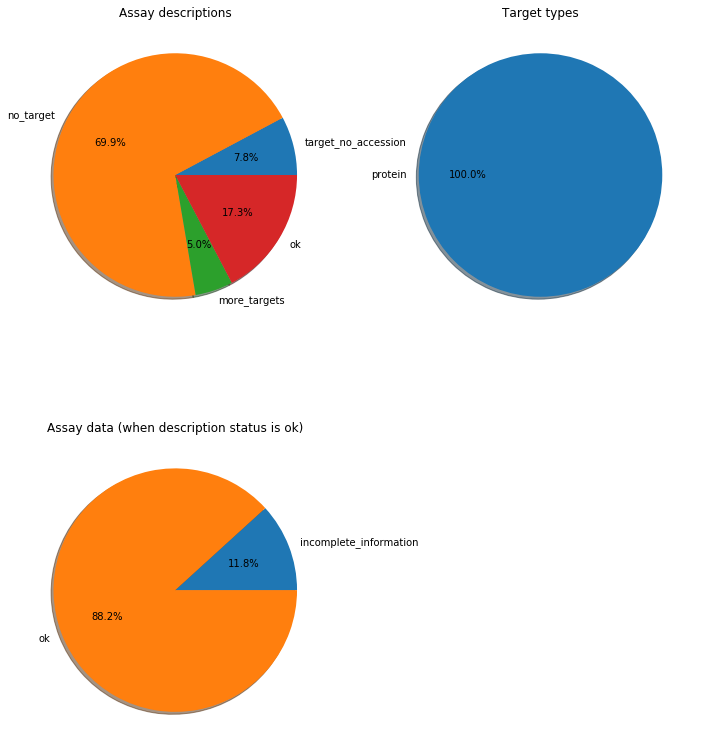

In [20]:
plt.figure(figsize=(12,14))

plt.subplot(221)
plt.title('Assay descriptions')
pie(desc_status_stats)

plt.subplot(222)
plt.title('Target types')
pie(target_types)

plt.subplot(223)
plt.title('Assay data (when description status is ok)')
pie(assay_status_stats)

In [27]:
df = pd.DataFrame(all_rows)

In [28]:
# df.fillna(value=pd.np.nan, inplace=True)

In [31]:
df.head(10)

,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_CID,PUBCHEM_RESULT_TAG,PUBCHEM_SID,Standard Relation,Standard Type,Standard Units,Standard Value,assay_id,assay_version,target_gi,target_id,target_name,target_protein_accession,target_type
0,Active,6167,1,103177124,=,IC50,nM,11.9,2979,8,None,1352387,Lanosterol synthase,P48449,protein
1,Active,628524,2,103231321,=,IC50,nM,60,2979,8,None,1352387,Lanosterol synthase,P48449,protein
2,Active,10386594,3,103310610,=,IC50,nM,2.7,2979,8,None,1352387,Lanosterol synthase,P48449,protein
3,Active,9973774,4,103310642,=,IC50,nM,82,2979,8,None,1352387,Lanosterol synthase,P48449,protein
4,Active,20039,1,103191505,=,EC50,nM,6000,2993,4,None,20141791,2-5A-dependent ribonuclease,Q05921,protein
5,Active,64975,2,103220966,=,EC50,nM,1200,2993,4,None,20141791,2-5A-dependent ribonuclease,Q05921,protein
6,Unspecified,135841357,3,103225076,>,EC50,nM,10000,2993,4,None,20141791,2-5A-dependent ribonuclease,Q05921,protein
7,Unspecified,135431125,4,103225564,>,EC50,nM,10000,2993,4,None,20141791,2-5A-dependent ribonuclease,Q05921,protein
8,Unspecified,135463029,5,103277154,>,EC50,nM,10000,2993,4,None,20141791,2-5A-dependent ribonuclease,Q05921,protein
9,Unspecified,135398739,6,103529091,>,EC50,nM,10000,2993,4,None,20141791,2-5A-dependent ribonuclease,Q05921,protein


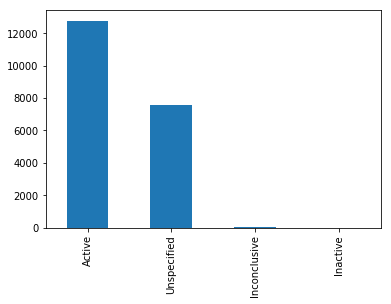

In [40]:
df.PUBCHEM_ACTIVITY_OUTCOME.value_counts().plot(kind='bar')

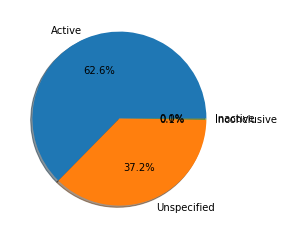

In [39]:
pie(df.PUBCHEM_ACTIVITY_OUTCOME)

In [ ]:
# Remove the files
# for batch_filename in tqdm_notebook(batch_sample):
#     batch = clean_up_batch(batch_filename)